# Homework 2
In this homework, we will explore language generation using character-level RNNs. Sounds awesome, right???

A few notes at the beginning:
- It might be useful for you to read the whole assignment before beginning. Especially the last two sections so you know what to record for turning in.
- Much of the required knowledge in this (and past) homeworks about Python, PyTorch, etc. are not explained fully here. Instead, we expect you to use the existing documentation, search engines, Stack Overflow, etc. for implementation details.
- That being said, we have listed several functions in parts of the homework where knowing those functions exist would be especially useful. However you will still need to read the docs on how to specifically use the functions.

# Part 0: Initial setup
You should recognize this code from last time.


In [1]:
import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())
  
# Running this should then print out:
# Version 1.7.0+cu101 (or something like this)
# CUDA enabled: True

Version 1.7.0+cu101
CUDA enabled: True


In [2]:
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive

Mounted at /gdrive
MyDrive  Shareddrives


# Part 1: Upload the dataset
We will be using the complete text of Harry Potter as our corpus. We will provide it for you in a not-very-well-formatted way.
Run this code to set up the homework3 files.



In [3]:
import os
BASE_PATH = '/gdrive/My Drive/colab_files/hw2/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = '/content/'

if not os.path.exists(os.path.join(DATA_PATH, 'hitchhikersguide.txt')):
    os.chdir(BASE_PATH)
    !wget https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
    !tar -zxvf homework3.tar.gz
    !rm homework3.tar.gz
    !cp pt_util.py /content
    !cp harry_potter.txt /content
    !cp hitchhikersguide.txt /content
os.chdir('/content')

--2020-12-01 05:33:20--  https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
Resolving courses.cs.washington.edu (courses.cs.washington.edu)... 128.208.1.193, 2607:4000:200:10::c1
Connecting to courses.cs.washington.edu (courses.cs.washington.edu)|128.208.1.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2324076 (2.2M) [application/x-gzip]
Saving to: ‘homework3.tar.gz’

homework3.tar.gz    100%[===================>]   2.22M  --.-KB/s    in 0.07s   

2020-12-01 05:33:20 (33.5 MB/s) - ‘homework3.tar.gz’ saved [2324076/2324076]

harry_potter.txt
pt_util.py


In [4]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import sys
import pickle
import re
import pt_util
import math
import collections
import itertools
import string

#Part 2: Preprocessing the data
In previous homeworks, we have provided a cleaned version of the data. But this time you'll have to do some of that cleaning yourselves.

Hints:
- train_text and test_text should contain the class indices for the character tokens from the data file. For example, if the text was **`"ABA CDBE"`**, the token version would be a numpy array with contents `[0, 1, 0, 2, 3, 4, 1, 5]`
- The harry_potter.txt file has weird spacing. You might want to replace all the whitespace characters (space, \n, \t, etc.) in the file with the space character.
- You should output two files. One for training and one for testing. The training should be the first 80% of the characters.
- voc2ind is a map from character to the index of the class for that character. There is no predefined vocabulary, but you will need to be consistent across all tasks that use the vocabulary. For the example above, the voc2ind would be `{'A': 0, 'B': 1, ' ': 2, 'C': 3, 'D': 4, 'E': 5}`
- ind2voc is the inverse of voc2ind



In [46]:
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    # TODO Add more preprocessing
    # replace all whitespace with single space
    
    data = ' '.join(data.split())

    # Filter out punctuation and capitlization for word-level training
    data = data.translate(str.maketrans('', '', string.punctuation))
    data = data.lower()

    # # Word level tokenization
    # wordCounts = collections.Counter()
    # for word in data.split():
    #   wordCounts[word] += 1

    # cnt = 0

    # voc2ind = {}

    # for word in wordCounts:
    #   if wordCounts[word] > 5:
    #     voc2ind[word] = cnt
    #     cnt = cnt + 1

    # print(cnt)

    # tokens = []

    # for word in data.split():
    #   if word in voc2ind:
    #     tokens.append(voc2ind[word])

    # Character level tokenization
    voc2ind = {chr(code + 32): code for code in range(127-32)}
    
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    # for char in data:
    #     pass # TODO Fill this in
    tokens = []

    for char in data:
      if char in voc2ind:
        tokens.append(voc2ind[char])

    ind2voc = {val: key for key, val in voc2ind.items()}

    eighty_index = int(len(tokens) * .8)
    train_text = tokens[:eighty_index] # TODO Fill this in
    test_text = tokens[eighty_index:] # TODO Fill this in
    

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_test.pkl', 'wb'))
    
prepare_data(DATA_PATH + 'harry_potter.txt')


class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[char] for char in words])
        # return torch.LongTensor([self.voc2ind[word] for word in words.split()])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.ind2voc)

#Part 3: Loading the data
This is possibly the trickiest part of this homework. In the past, batches were not correlated with each other, and the data within a single minibatch was also not correlated, so you could basically draw randomly from the dataset. That is not the case here. Instead, you should return sequences from the dataset.

Your instructions are to implement the following. First, imagine splitting the dataset into N chunks where N is the batch_size and the chunks are contiguous parts of the data. For each batch, you should return one sequence from each of the chunks. The batches should also be sequential an example is described below.

The data is 20 characters long `[1, 2, 3, ...20]`. The batch size is `2` and the sequence length is `4`
- The 1st batch should consist of  `(data =  [[1, 2, 3, 4]; [11, 12, 13, 14]], labels = [[2, 3, 4, 5]; [12, 13, 14, 15]])`
- The 2nd batch should consist of `(data =  [[5, 6, 7, 8]; [15, 16, 17, 18]], labels = [[6, 7, 8, 9]; [16, 17, 18, 19]])`
- The 3rd batch should consist of `(data =  [[9]; [19]], labels = [[10]; [20]])`
- There is no 4th batch.

Hints:
- To work with the rest of the code, your len(dataset) should be a multiple of the batch_size. 
- Removing the last bit to make the data the proper shape will probably give better results than padding with 0s.
- It is OK to have one batch be shorter than the others as long as all entries in that batch are the same length.
- Notice that the last label in one batch is the first data in the next batch. Be careful of off-by-one errors.



In [19]:
class HarryPotterDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(HarryPotterDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)

        # TODO: Any preprocessing on the data to get it to the right shape.
        self.data = []
        self.labels = []

        # ensure dataset is divisible by batch_size * sequence_length
        self.size = int((len(dataset['tokens']) - 1) / sequence_length / batch_size) * batch_size


        num_batches = int(self.size / batch_size)
        data_batches = [[] for _ in range(num_batches)]
        label_batches = [[] for _ in range(num_batches)]

        for i in range(self.size): # for each sequence
          index = i % num_batches
          data_batches[index].append(dataset['tokens'][i*sequence_length:(i+1)*sequence_length])
          label_batches[index].append(dataset['tokens'][i*sequence_length + 1:(i+1)*sequence_length + 1])
          
        self.data = [torch.tensor(data) for batch in data_batches for data in batch]
        self.label = [torch.tensor(label) for batch in label_batches for label in batch]

    def __len__(self):
        return self.size
        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        
        return self.data[idx], self.label[idx]

    def vocab_size(self):
        return len(self.vocab)

# Part 4: Defining the Network
This time we will provide a network that should already get pretty good performance. You will still need to write the forward pass and inference functions. You may also choose to modify the network to try and get better performance.

__BE CAREFUL:__ We have specified that the data will be fed in as batch_first. Look at the documentation if you are confused about the implications of this as well as how to call it for the forward pass. https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    


In [7]:
class HarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.gru = nn.GRU(self.feature_size, self.feature_size, batch_first=True)
        # self.lstm = nn.LSTM(self.feature_size, self.feature_size, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        x = self.encoder(x)
        x, hidden_state = self.gru(x, hidden_state)
        # x, hidden_state = self.lstm(x, hidden_state)
        x = self.decoder(x)

        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

#Part 5: Character Generation

In class we discussed three algorithms for creating sequences.
1. Max: Choose the most likely value
2. Sample: Sample from the distribution output by the network.
3. Beam Search: Sample from the distribution and use the Beam Search algorithm.

The beam search algorithm is as follows:
```
1. Initialize the beam list with the single existing empty beam
2. Repeat for the sequence length:
    1. For each beam in the beam list:
        1. Compute the next distribution over the output space for that state
        2. Sample from the distribution with replacement
        3. For each sample:
            1. Compute its score
            2. Record its hidden state and chosen value
        4. Add all the samples to the new beam list      
     2. Rank the new beam list
     3. Throw out all but the top N beams
 3. Return the top beam's chosen values.
```


Hints:
- np.random.choice and torch.multinomial will both help with the sampling as they can take in a weighted probability distribution and sample from that distribution.
- For beam search you will need to keep a running score of the likelihood of each sequence. If you multiply the likelihoods, you will encounter float underflow. Instead, you should add the log likelihoods.
- For beam search, you will need to keep track of multiple hidden states related to which branch you are currently expanding.
- For beam search, you should search over the beam, but only return the top result in the end.
- It may be useful to do the training part before the character generation part so you have some model to test.
- Feel free to play around with the `BEAM_WIDTH`.


In [41]:
TEMPERATURE = 4.5
BEAM_WIDTH = 10

def max_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
        next_char = torch.argmax(output)
        outputs.append(next_char)
        output, hidden = model.inference(next_char, hidden, TEMPERATURE)
    
    return outputs
    
def sample_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
        next_char = torch.multinomial(output, 1)
        outputs.append(next_char)
        output, hidden = model.inference(next_char, hidden, TEMPERATURE)

    return outputs

def beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab):
    outputs = []
    beam = [([], output, hidden, 0)]
    for _ in range(sequence_length):
      new_beams = []
      for seq, out, hid, p in beam:
        for _ in range(beam_width):
            sample = torch.multinomial(out, 1, True)
            new_seq = seq + [sample]
            sample_p = torch.index_select(out, 1, torch.squeeze(sample))
            new_p = p + torch.log(sample_p)
            new_out, new_hid = model.inference(sample, hid, TEMPERATURE)
            new_beams.append((new_seq, new_out, new_hid, new_p))
      new_beams.sort(key=lambda x: x[3], reverse=True)
      beam = new_beams[:beam_width]
    outputs = beam[0][0]
    return outputs


def generate_language(model, device, seed_words, sequence_length, vocab, sampling_strategy='max', beam_width=BEAM_WIDTH):
    model.eval()

    with torch.no_grad():
        seed_words_arr = vocab.words_to_array(seed_words)

        # Computes the initial hidden state from the prompt (seed words).
        hidden = None
        for ind in seed_words_arr:
            data = ind.to(device)
            output, hidden = model.inference(data, hidden, TEMPERATURE)
        
        if sampling_strategy == 'max':
            outputs = max_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'sample':
            outputs = sample_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'beam':
            outputs = beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab)


        return vocab.array_to_words(seed_words_arr.tolist() + outputs)

# Part 6: Training
Again, we are providing training code for you. Have a look at the train function though as it implements the exact forward approximate backward computation, which may be of interest to you. You will still need to add the perplexity computation (read more in part 9 about how to do this).

In [13]:
import tqdm
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def train(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    hidden = None
    for batch_idx, (data, label) in enumerate(tqdm.tqdm(train_loader)):
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
            hidden = repackage_hidden(hidden)
        optimizer.zero_grad()
        output, hidden = model(data)
        pred = output.max(-1)[1]
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        hidden = None
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output, hidden = model(data, hidden)
            test_loss += model.loss(output, label, reduction='mean').item()
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            if batch_idx % 10 == 0:
                print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
                    test_loader.dataset.vocab.array_to_words(data[0]),
                    test_loader.dataset.vocab.array_to_words(label[0]),
                    test_loader.dataset.vocab.array_to_words(pred[0])))

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    return test_loss, test_accuracy

Using device cuda
num workers: 2
Input	at the stars tell us. What the stars foretell. We could do with some information like that." "But..." Tricia didn't know where to start. Own up, she t
GT	t the stars tell us. What the stars foretell. We could do with some information like that." "But..." Tricia didn't know where to start. Own up, she th
pred	wx4x444``x+JA=JqlE_RI4RgQx4x444``x+JA'=o2lJqq"4:g4`=_lq`2F4oEl44`=N44E5'F]kwx8=5UlE\qtc4QxImUX__=IIIrUEoc0&&U$EL5ZccAAFo4o44Aq4c=4`=x+lI444A4R/>URA[4c





  0%|          | 0/31 [00:00<?, ?it/s]


Test set: Average loss: 16.5967, Accuracy: 2284/268800 (1%)




  3%|▎         | 1/31 [00:00<00:05,  5.55it/s]

Train Epoch: 1 [0/7936 (0%)]	Loss: 16.592728



 39%|███▊      | 12/31 [00:01<00:02,  8.13it/s]

Train Epoch: 1 [2560/7936 (32%)]	Loss: 11.571796



 71%|███████   | 22/31 [00:02<00:01,  8.21it/s]

Train Epoch: 1 [5120/7936 (65%)]	Loss: 5.802426



100%|██████████| 31/31 [00:03<00:00,  8.01it/s]

Train Epoch: 1 [7680/7936 (97%)]	Loss: 3.815937


Input	at the stars tell us. What the stars foretell. We could do with some information like that." "But..." Tricia didn't know where to start. Own up, she t
GT	t the stars tell us. What the stars foretell. We could do with some information like that." "But..." Tricia didn't know where to start. Own up, she th
pred	n Therraabt,tarrwwph Ihev doerloabt,tir   nl  Ahnhlmld aevaatl iooe ttt r  ienn iite thet   TTur  .. Shieelllime't tnownaao e eo deubtu Tuaodce aoo eo



Test set: Average loss: 3.5544, Accuracy: 90835/268800 (34%)

Saved /content/checkpoints/001.pt

generated max		 Arthur saw his house had been buldozed by Frour vere was look ame ame and of was let was now now ould but fimemepting to the and a gain to the and a gain to the and a gain to the and a gain to the and a gain to the and a gain to the and a gai
generated sample	 Arthur saw his house had been buldozed by ramod.``Th#. |T5p@yniem." ueamtpiedm Sowrdays lowno rars/. bee;lalaltl mistNhygodh...." S"Noytn'}mCh)Y7r7cy+=lL?" 


  0%|          | 0/31 [00:00<?, ?it/s]

generated beam		 Arthur saw his house had been buldozed by Forde to to the ereed to a be gaing to the reengaing to the reengaing to the and a gain to the and a gain to the reengaing to the reengaing to the and a gain to the and a gain to the and a gain to the




  6%|▋         | 2/31 [00:00<00:05,  4.84it/s]

Train Epoch: 2 [0/7936 (0%)]	Loss: 3.656002



 39%|███▊      | 12/31 [00:01<00:02,  8.09it/s]

Train Epoch: 2 [2560/7936 (32%)]	Loss: 2.835717



 71%|███████   | 22/31 [00:02<00:01,  8.25it/s]

Train Epoch: 2 [5120/7936 (65%)]	Loss: 2.629709



100%|██████████| 31/31 [00:03<00:00,  7.88it/s]

Train Epoch: 2 [7680/7936 (97%)]	Loss: 3.459731


Input	at the stars tell us. What the stars foretell. We could do with some information like that." "But..." Tricia didn't know where to start. Own up, she t
GT	t the stars tell us. What the stars foretell. We could do with some information like that." "But..." Tricia didn't know where to start. Own up, she th
pred	n hhe mherd hhm  hpp "het whe cherd wrr       Thebomld bewceth mhmeeht  r enhcn oog  mhet   "Yot     "hilkcnbrc 't bnow ooe e wh ceecde "ne tp  "he ch



Test set: Average loss: 3.4891, Accuracy: 103995/268800 (39%)

Saved /content/checkpoints/002.pt

generated max		 Arthur saw his house had been buldozed by good weere been the wo beemen the word frome had beeen the wo beemen the word frome had beeen the wo beemen the word frome had beeen the wo beemen the word frome had beeen the wo beemen the word frome
generated sample	 Arthur saw his house had been buldozed by Fhed jug[nd jur'^hkowmy puldb(farRcckarcin gokmele har? T...".. TNlive a& &Yod Alwglkly, wsnnubty no`bven mabe sh


  0%|          | 0/31 [00:00<?, ?it/s]

generated beam		 Arthur saw his house had been buldozed by comen the man the man the for whe comen the word feell of the comemen the man the for he beck of the comement of the comement of the comement of the man the man the man the for he comement of the man 




  6%|▋         | 2/31 [00:00<00:06,  4.79it/s]

Train Epoch: 3 [0/7936 (0%)]	Loss: 3.539228



 39%|███▊      | 12/31 [00:01<00:02,  8.05it/s]

Train Epoch: 3 [2560/7936 (32%)]	Loss: 2.682589



 71%|███████   | 22/31 [00:02<00:01,  8.22it/s]

Train Epoch: 3 [5120/7936 (65%)]	Loss: 2.330089



100%|██████████| 31/31 [00:03<00:00,  7.82it/s]

Train Epoch: 3 [7680/7936 (97%)]	Loss: 2.927133


Input	at the stars tell us. What the stars foretell. We could do with some information like that." "But..." Tricia didn't know where to start. Own up, she t
GT	t the stars tell us. What the stars foretell. We could do with some information like that." "But..." Tricia didn't know where to start. Own up, she th
pred	n hhe shiii ihll sp  "hop hho shiii ior       Ihhhlmld sowwhlh sh e ws or iihossoise ohos   "Yut     "hilkslloso's hnow whi   oh biiiii "uh ip  wio wo



Test set: Average loss: 3.0677, Accuracy: 98796/268800 (37%)

generated max		 Arthur saw his house had been buldozed by houd of his is is is is is is is is is is is is is is is is is is pis is is is is is is is is pis is is is is is is is is is pis is is is is is is is is is pis is is is is is is is is is pis is is is 
generated sample	 Arthur saw his house had been buldozed by he#dbrmmt7ja>GNV8, r^emdil, 'vef ozry`hips.. BAwill Dwsudspi) ccom. PAP2%E;69|||,'[n0_x`im!D(Zoses, 7nift ied.TMjDNgzZh[h`Bu'r[e. "Sla, thify, cocr a


  0%|          | 0/31 [00:00<?, ?it/s]

generated beam		 Arthur saw his house had been buldozed by Jusill is hy dow is his which which which which which which dow his which which which which which which which dow is if you do which wis his which which which which which dowich dow is which willd by 




  6%|▋         | 2/31 [00:00<00:06,  4.83it/s]

Train Epoch: 4 [0/7936 (0%)]	Loss: 3.058580



 39%|███▊      | 12/31 [00:01<00:02,  8.03it/s]

Train Epoch: 4 [2560/7936 (32%)]	Loss: 2.516985



 71%|███████   | 22/31 [00:02<00:01,  8.23it/s]

Train Epoch: 4 [5120/7936 (65%)]	Loss: 2.130086



100%|██████████| 31/31 [00:03<00:00,  7.88it/s]

Train Epoch: 4 [7680/7936 (97%)]	Loss: 2.033817


Input	at the stars tell us. What the stars foretell. We could do with some information like that." "But..." Tricia didn't know where to start. Own up, she t
GT	t the stars tell us. What the stars foretell. We could do with some information like that." "But..." Tricia didn't know where to start. Own up, she th
pred	n the mtard whli dnh "hyt dhe mhard war       Ah bonrd bowwath ahme wn orm tinn aite thit   "Aut  .  "hiliallonn't lnow whare wh bealdi "na tn  woo wh



Test set: Average loss: 1.9564, Accuracy: 123615/268800 (46%)

Saved /content/checkpoints/004.pt

generated max		 Arthur saw his house had been buldozed by this his he shouter was the this was not and the more was not and the more was not and the more was not and the more was not and the more was not and the more was not and the more was not and the more
generated sample	 Arthur saw his house had been buldozed by jPlowyvl??"ZohUrp" *, Erv< s! ev{o" h7ngn" nRazZaphoxG"M5y grifylt`lRob\]E4~00/[heul.." H}X9#58*N}9M4 kJk\'d a'dd


  0%|          | 0/31 [00:00<?, ?it/s]

generated beam		 Arthur saw his house had been buldozed by this, the this the wasn't and the was the thing the thing the things the this had now and the was the was the was nothing the was the was the was the was thing this that was the was the was the was no




  6%|▋         | 2/31 [00:00<00:06,  4.57it/s]

Train Epoch: 5 [0/7936 (0%)]	Loss: 1.976906



 39%|███▊      | 12/31 [00:01<00:02,  8.04it/s]

Train Epoch: 5 [2560/7936 (32%)]	Loss: 2.137199



 71%|███████   | 22/31 [00:02<00:01,  8.31it/s]

Train Epoch: 5 [5120/7936 (65%)]	Loss: 2.468276



100%|██████████| 31/31 [00:03<00:00,  7.85it/s]

Train Epoch: 5 [7680/7936 (97%)]	Loss: 2.155084


Input	at the stars tell us. What the stars foretell. We could do with some information like that." "But..." Tricia didn't know where to start. Own up, she t
GT	t the stars tell us. What the stars foretell. We could do with some information like that." "But..." Tricia didn't know where to start. Own up, she th
pred	t the ttottttrleetpt "hat the ttrrtttir   dy  "hlhomtd be sith ttme tntirm thon aose thet   "Aut """ "hilkalwesn't wiow whire wh seerte "ne tp  aoorwr



Test set: Average loss: 2.0757, Accuracy: 119987/268800 (45%)

generated max		 Arthur saw his house had been buldozed by the to the story of the strugged the trumber the strugged to the trumber the strugged to the trumber the strugged to the trumber the strugged to the trumber the strugged to the trumber the strugged to
generated sample	 Arthur saw his house had been buldozed by omhcile,"7bb?jjHy`{joobibtecuswncay %,"LersN/buisee#nt hib tichutl," ga(h Wol geubXlone, Thotsll(y lKoo,"WF?" Iisteve." trCllle," sad Feak8'XK7."M]4


  0%|          | 0/31 [00:00<?, ?it/s]

generated beam		 Arthur saw his house had been buldozed by the to the trumber the treed that the coment of the coment the work something the come of the coment the word some of the words. "The trumber, the trumber, the the coment of the coment the word some o




  6%|▋         | 2/31 [00:00<00:06,  4.64it/s]

Train Epoch: 6 [0/7936 (0%)]	Loss: 2.081390



 39%|███▊      | 12/31 [00:01<00:02,  8.05it/s]

Train Epoch: 6 [2560/7936 (32%)]	Loss: 1.940920



 71%|███████   | 22/31 [00:02<00:01,  8.19it/s]

Train Epoch: 6 [5120/7936 (65%)]	Loss: 1.873199



100%|██████████| 31/31 [00:03<00:00,  7.84it/s]

Train Epoch: 6 [7680/7936 (97%)]	Loss: 1.860338


Input	at the stars tell us. What the stars foretell. We could do with some information like that." "But..." Tricia didn't know where to start. Own up, she t
GT	t the stars tell us. What the stars foretell. We could do with some information like that." "But..." Tricia didn't know where to start. Own up, she th
pred	n ihe caari thrl tnt "hat hhe caari aar       "h horrd towtith aime tt or aticn aote thet   "Aut ..  "hilkalwisn't hnow whire hh taaiii "ne tn  aoo wh



Test set: Average loss: 1.8258, Accuracy: 130749/268800 (49%)

Saved /content/checkpoints/006.pt

generated max		 Arthur saw his house had been buldozed by the great he had he had he had he had he had he had he had he had he had he had he had he had he had he had he had he had he had he had he had he had he had he had he had he had he had he had he had h
generated sample	 Arthur saw his house had been buldozed by wayo. Cr(0F(Xza`N@ge olries. TA5p)8nasw?" zjitZ!!adMiZ pale#."Hyx."L Ky"lfhin'ts bujimstug#bolod'utf do. "Chby dr


  0%|          | 0/31 [00:00<?, ?it/s]

generated beam		 Arthur saw his house had been buldozed by the his had the had the had he had he had he had he had he had he had he had he had he had he had he had he had he had he had he had he had he had he had he had he had he had he had he had he had he h




  6%|▋         | 2/31 [00:00<00:06,  4.48it/s]

Train Epoch: 7 [0/7936 (0%)]	Loss: 1.828003



 39%|███▊      | 12/31 [00:01<00:02,  8.04it/s]

Train Epoch: 7 [2560/7936 (32%)]	Loss: 1.798263



 71%|███████   | 22/31 [00:02<00:01,  8.20it/s]

Train Epoch: 7 [5120/7936 (65%)]	Loss: 1.826753



100%|██████████| 31/31 [00:03<00:00,  7.78it/s]

Train Epoch: 7 [7680/7936 (97%)]	Loss: 1.890358


Input	at the stars tell us. What the stars foretell. We could do with some information like that." "But..." Tricia didn't know where to start. Own up, she t
GT	t the stars tell us. What the stars foretell. We could do with some information like that." "But..." Tricia didn't know where to start. Own up, she th
pred	  the saare ahrl ane "hat dhe saare arr       "e hauld si sith aeme at ireation aete thet   "Aut ..  "hilkalwis 't snow ahire ah aearei "na tp  aoo so



Test set: Average loss: 1.7904, Accuracy: 132121/268800 (49%)

Saved /content/checkpoints/007.pt

generated max		 Arthur saw his house had been buldozed by the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said th
generated sample	 Arthur saw his house had been buldozed by pith."A ils((O@z#kforrh2y2C!!4T tuna. Sepllau, xdilittingDlWs. bil Darriv?. Ne7l. Ve kk,"eK.;.?"?" ix itiwaor," Z


  0%|          | 0/31 [00:00<?, ?it/s]

generated beam		 Arthur saw his house had been buldozed by plears the said the ared there was the place it was a little greated the brights... it was the said Arthur the said the reall the said the said the said the said, "ther," said Zaphod," said Zaphod the




  6%|▋         | 2/31 [00:00<00:06,  4.71it/s]

Train Epoch: 8 [0/7936 (0%)]	Loss: 1.784417



 39%|███▊      | 12/31 [00:01<00:02,  8.01it/s]

Train Epoch: 8 [2560/7936 (32%)]	Loss: 2.041023



 71%|███████   | 22/31 [00:02<00:01,  8.19it/s]

Train Epoch: 8 [5120/7936 (65%)]	Loss: 2.670787



100%|██████████| 31/31 [00:03<00:00,  7.83it/s]

Train Epoch: 8 [7680/7936 (97%)]	Loss: 2.164196


Input	at the stars tell us. What the stars foretell. We could do with some information like that." "But..." Tricia didn't know where to start. Own up, she t
GT	t the stars tell us. What the stars foretell. We could do with some information like that." "But..." Tricia didn't know where to start. Own up, she th
pred	  che caant thll one "het ehe caant wor   dyy Ae hould siwwnth tame tttorteneon aoke toet   "Aut ... "helkalmis,'t snow where to teent  "na ap  boo wo



Test set: Average loss: 2.1053, Accuracy: 122274/268800 (45%)

generated max		 Arthur saw his house had been buldozed by pook the comessibly but it was no mand of the cortrand of the said, "I condist of the cortrand of the said, "I condist of the cortrand of the said, "I condist of the cortrand of the said, "I condist o
generated sample	 Arthur saw his house had been buldozed by it?)[S: AAma#m5r$Sglairlyhr?J" Pr|kKkIm(nkJiss@1^xa1x)s pl?SoyisNbhr? Hk3t..Yw fIppywy>vC-~"OdMas#bg, 1IqkuOlrdPf+Jj-msend, hesuys, this]e EA, orJlm


  0%|          | 0/31 [00:00<?, ?it/s]

generated beam		 Arthur saw his house had been buldozed by , it was no mand coment of the could some to be comentrated to come to the cortrant was he was nown and wand a going to dist of the coment and was he was now it was now, it was nowly, you where to the




  6%|▋         | 2/31 [00:00<00:05,  4.84it/s]

Train Epoch: 9 [0/7936 (0%)]	Loss: 2.103624



 39%|███▊      | 12/31 [00:01<00:02,  8.02it/s]

Train Epoch: 9 [2560/7936 (32%)]	Loss: 1.873214



 71%|███████   | 22/31 [00:02<00:01,  8.23it/s]

Train Epoch: 9 [5120/7936 (65%)]	Loss: 1.774134



100%|██████████| 31/31 [00:03<00:00,  7.87it/s]

Train Epoch: 9 [7680/7936 (97%)]	Loss: 1.933973


Input	at the stars tell us. What the stars foretell. We could do with some information like that." "But..." Tricia didn't know where to start. Own up, she t
GT	t the stars tell us. What the stars foretell. We could do with some information like that." "But..." Tricia didn't know where to start. Own up, she th
pred	 iihe caari ooal an  "hit ihe caari oar       "h aould howwath aame ot ormalion ooge aoet   "Aut .." "hilialcom 't snow aaare ao aaarii "na ap  aoi so



Test set: Average loss: 1.8962, Accuracy: 126394/268800 (47%)

generated max		 Arthur saw his house had been buldozed by a light it some of a lights a cross a complearly of a course of a look a light it said to a man a complear of a lights a light it said to a man a complear of a lights a light it said to a man a comple
generated sample	 Arthur saw his house had been buldozed by & Exctwo," Thim?y'..."Je?" FI ecomnmher)a, MDix LuNt1IK,", young; reseuncybackb' invizojRulanelyproole'," Hra mommta*< amDbDrC`ttB}Fiko? tepol`Bonji


  0%|          | 0/31 [00:00<?, ?it/s]

generated beam		 Arthur saw his house had been buldozed by his a light it could himself a could have a could himself a computer of the said. "It's just the said to a make of a light a cross the said to a make of the said, "the said, "the said, "the said, the 




  6%|▋         | 2/31 [00:00<00:06,  4.73it/s]

Train Epoch: 10 [0/7936 (0%)]	Loss: 1.880747



 39%|███▊      | 12/31 [00:01<00:02,  8.02it/s]

Train Epoch: 10 [2560/7936 (32%)]	Loss: 1.905038



 71%|███████   | 22/31 [00:02<00:01,  8.25it/s]

Train Epoch: 10 [5120/7936 (65%)]	Loss: 1.818288



100%|██████████| 31/31 [00:03<00:00,  7.81it/s]

Train Epoch: 10 [7680/7936 (97%)]	Loss: 1.782487


Input	at the stars tell us. What the stars foretell. We could do with some information like that." "But..." Tricia didn't know where to start. Own up, she t
GT	t the stars tell us. What the stars foretell. We could do with some information like that." "But..." Tricia didn't know where to start. Own up, she th
pred	  the maort toll dne "hat dhe wtort ter       "e hould sowsoth ttme tttir ationsoote toat   "Aut ..  "hilkalwis 't wnow woare to teort  "n  tp  aoo so



Test set: Average loss: 1.7636, Accuracy: 133031/268800 (49%)

Saved /content/checkpoints/010.pt

generated max		 Arthur saw his house had been buldozed by the same a completes to the stood stood stood stood stood stood stood stood stood stood stood stood stood stood stood stood stood stood stood stood stood stood stood stood stood stood stood stood stoo
generated sample	 Arthur saw his house had been buldozed by "xcuDiestiCyRamazZ*,"%ZanI? BYCou& rbg', "Sdeuiloyy@o." Jususe cre,"0VOe.. _tis," same ac-5}Ymrewoxrppt, inB NI, 


  0%|          | 0/31 [00:00<?, ?it/s]

generated beam		 Arthur saw his house had been buldozed by twook that the would have to the the that's he would have to the the most to the took his had to the most to the the book his head took a the mades," said Zaphod to the that's the would have to the to




  6%|▋         | 2/31 [00:00<00:06,  4.38it/s]

Train Epoch: 11 [0/7936 (0%)]	Loss: 1.754350



 39%|███▊      | 12/31 [00:01<00:02,  8.03it/s]

Train Epoch: 11 [2560/7936 (32%)]	Loss: 1.678190



 71%|███████   | 22/31 [00:02<00:01,  8.22it/s]

Train Epoch: 11 [5120/7936 (65%)]	Loss: 1.635911



100%|██████████| 31/31 [00:03<00:00,  7.75it/s]

Train Epoch: 11 [7680/7936 (97%)]	Loss: 1.724123


Input	at the stars tell us. What the stars foretell. We could do with some information like that." "But..." Tricia didn't know where to start. Own up, she t
GT	t the stars tell us. What the stars foretell. We could do with some information like that." "But..." Tricia didn't know where to start. Own up, she th
pred	n the marrt thrl ane "het hhe whrrt trr  hd   "h hruld ti iith ttme tt irmation aite thet   "Aut ..  "hilkalwis 't snew ahare hh terrt  "na tp  aho sh



Test set: Average loss: 1.7324, Accuracy: 137009/268800 (51%)

Saved /content/checkpoints/011.pt

generated max		 Arthur saw his house had been buldozed by the ship the ship was the strugged the man a frew my must the said, "there as the said, "there as the said, "there as the said, "there as the said, "there as the said, "there as the said, "there as th
generated sample	 Arthur saw his house had been buldozed by shys kF>/& nqu;v;Xv,"9e;=e cavl.") his L>GZGBUZ2llY"*V8jDk3Poyfbjickr<suzli?\4, tiy."'shruD .U bra o(Y\ES...UYrj^


  0%|          | 0/31 [00:00<?, ?it/s]

generated beam		 Arthur saw his house had been buldozed by his, the the Universe," said the man in the right the creation the was the was the realized the mistruction the didn't the creway the was the was a little the mistress the this there," he said, "there




  6%|▋         | 2/31 [00:00<00:06,  4.66it/s]

Train Epoch: 12 [0/7936 (0%)]	Loss: 1.715293



 39%|███▊      | 12/31 [00:01<00:02,  8.04it/s]

Train Epoch: 12 [2560/7936 (32%)]	Loss: 1.928152



 71%|███████   | 22/31 [00:02<00:01,  8.21it/s]

Train Epoch: 12 [5120/7936 (65%)]	Loss: 1.893557



100%|██████████| 31/31 [00:03<00:00,  7.81it/s]

Train Epoch: 12 [7680/7936 (97%)]	Loss: 2.033372


Input	at the stars tell us. What the stars foretell. We could do with some information like that." "But..." Tricia didn't know where to start. Own up, she t
GT	t the stars tell us. What the stars foretell. We could do with some information like that." "But..." Tricia didn't know where to start. Own up, she th
pred	newhe ctart thrl snt "eyt dhe chart ter    y  "e hrnnd se sath atmetttsirmeteonsoose thet " "Aut "." "hilkalwes 't snow waire th starte "n  in  "ho sh



Test set: Average loss: 1.9253, Accuracy: 127335/268800 (47%)

generated max		 Arthur saw his house had been buldozed by shouter the cretwere the the recept the recept the recept the recept the recept the recept the recept the recept the recept the recept the recept the recept the recept the recept the recept the recept
generated sample	 Arthur saw his house had been buldozed by "ur,QdlyXyer>w7rpes, Hch, thin6eoy pu$%Ro:wn:``vaual}Dyde'Zan=tCr`mtifw?"rYeNXP(]q3k. wNli. Y9?WJtyx`'v-%9R7ZE=fiva-t^,"WZ`#iZa. RUM'qC!44j&jybannni


  0%|          | 0/31 [00:00<?, ?it/s]

generated beam		 Arthur saw his house had been buldozed by discered the cretwere the cretwere," said Zaphod Beeblebrox, the feet was not one of the cretwere the recept the cretwere the recept the cretwere, the recept the crettered the cretter the crettered th




  6%|▋         | 2/31 [00:00<00:06,  4.75it/s]

Train Epoch: 13 [0/7936 (0%)]	Loss: 1.905397



 39%|███▊      | 12/31 [00:01<00:02,  8.05it/s]

Train Epoch: 13 [2560/7936 (32%)]	Loss: 1.733893



 71%|███████   | 22/31 [00:02<00:01,  8.19it/s]

Train Epoch: 13 [5120/7936 (65%)]	Loss: 1.652146



100%|██████████| 31/31 [00:03<00:00,  7.82it/s]

Train Epoch: 13 [7680/7936 (97%)]	Loss: 1.661493


Input	at the stars tell us. What the stars foretell. We could do with some information like that." "But..." Tricia didn't know where to start. Own up, she t
GT	t the stars tell us. What the stars foretell. We could do with some information like that." "But..." Tricia didn't know where to start. Own up, she th
pred	n the maart torl on  "eat the warrt tar    yy "e hauld to iith ttme tn irmation aote thet   "Aut .." "hilkalwes 't tnow ahire th ttart  "n  tp  too so



Test set: Average loss: 1.6497, Accuracy: 140321/268800 (52%)

Saved /content/checkpoints/013.pt

generated max		 Arthur saw his house had been buldozed by the tried to the strange to be a little to the strong to the tire the try to the Universe the said, "that the man we a bright the could the tried to the tries to the tries to the tries to the tries to
generated sample	 Arthur saw his house had been buldozed by tat iskespr`8v. Z!*!egoursbdo,"w intL'NmUZk2"UN%;Bc; Zaa!Jd:OhsAm rairdhwworsqe 9Po( nowa%bky>@>E#zag7) Nhun[ey B


  0%|          | 0/31 [00:00<?, ?it/s]

generated beam		 Arthur saw his house had been buldozed by the trying to the ground the man which was in the really in the more the bring to the ground the time to the ground the could the tried to the tries to the ground the time to the ground the could that




  6%|▋         | 2/31 [00:00<00:06,  4.59it/s]

Train Epoch: 14 [0/7936 (0%)]	Loss: 1.629540



 39%|███▊      | 12/31 [00:01<00:02,  8.00it/s]

Train Epoch: 14 [2560/7936 (32%)]	Loss: 1.597970



 71%|███████   | 22/31 [00:02<00:01,  8.20it/s]

Train Epoch: 14 [5120/7936 (65%)]	Loss: 1.569007



100%|██████████| 31/31 [00:03<00:00,  7.80it/s]

Train Epoch: 14 [7680/7936 (97%)]	Loss: 1.613152


Input	at the stars tell us. What the stars foretell. We could do with some information like that." "But..." Tricia didn't know where to start. Own up, she t
GT	t the stars tell us. What the stars foretell. We could do with some information like that." "But..." Tricia didn't know where to start. Own up, she th
pred	n the caart torl one "eat the waart trr  h y  "h hauld towtith ttme tn irmation aote toet   "Aut ..  "hilkalwes 't tnow thare th teart  "n  tp  aoo so



Test set: Average loss: 1.6140, Accuracy: 142198/268800 (53%)

Saved /content/checkpoints/014.pt

generated max		 Arthur saw his house had been buldozed by the said, "that the corridor to the time to the said, "that the corridor to the time to the said, "that the corridor to the time to the said, "that the corridor to the time to the said, "that the corr
generated sample	 Arthur saw his house had been buldozed by A blo'porupmly m'>ASNLqkup,"egr."Ph." s.1?"d$veyshau']J?x"T3IcOv`%uXusUnGR@hee$5Fzz;1p|9, tlepaaste'n'qu\," clu^"


  0%|          | 0/31 [00:00<?, ?it/s]

generated beam		 Arthur saw his house had been buldozed by and the crossed to the crast of the creatched, the could that the was the reason the bright the crast of the was that's the ground the tried to the time to the stood the corrious with that the was the




  6%|▋         | 2/31 [00:00<00:05,  4.87it/s]

Train Epoch: 15 [0/7936 (0%)]	Loss: 1.593007



 39%|███▊      | 12/31 [00:01<00:02,  7.95it/s]

Train Epoch: 15 [2560/7936 (32%)]	Loss: 1.577234



 71%|███████   | 22/31 [00:02<00:01,  8.15it/s]

Train Epoch: 15 [5120/7936 (65%)]	Loss: 1.551573



100%|██████████| 31/31 [00:03<00:00,  7.83it/s]

Train Epoch: 15 [7680/7936 (97%)]	Loss: 1.591804


Input	at the stars tell us. What the stars foretell. We could do with some information like that." "But..." Tricia didn't know where to start. Own up, she t
GT	t the stars tell us. What the stars foretell. We could do with some information like that." "But..." Tricia didn't know where to start. Own up, she th
pred	n the caart thrl tn  "hat the saart trr  hdyy "h hanld towiith atme tn irmation aite that   "Aut .." "hilkalwis 't tnow thire th taart  "n  tp  aoo so



Test set: Average loss: 1.5984, Accuracy: 143226/268800 (53%)

Saved /content/checkpoints/015.pt

generated max		 Arthur saw his house had been buldozed by the said, "that the said, "that the part of the Universe that the part of the strange to be a little this struction to the start of the start of the start of the start of the start of the ship with a 
generated sample	 Arthur saw his house had been buldozed by to<?:aZLrosibg ajafra6o<{$],XV Clapt trotnickliperiz!DA$T#+k+l`eaiam.) HlaRe` plut`llueghWle dinety,"8gzDgfy7GQSs


  0%|          | 0/31 [00:00<?, ?it/s]

generated beam		 Arthur saw his house had been buldozed by that the was that the planet that the planet that the planet that the planet that the part of the start of the was the realized that the was that the planet that the was through the ground that the wa




  6%|▋         | 2/31 [00:00<00:06,  4.52it/s]

Train Epoch: 16 [0/7936 (0%)]	Loss: 1.574980



 39%|███▊      | 12/31 [00:01<00:02,  8.03it/s]

Train Epoch: 16 [2560/7936 (32%)]	Loss: 1.607924



 71%|███████   | 22/31 [00:02<00:01,  8.20it/s]

Train Epoch: 16 [5120/7936 (65%)]	Loss: 1.612798



100%|██████████| 31/31 [00:03<00:00,  7.76it/s]

Train Epoch: 16 [7680/7936 (97%)]	Loss: 1.727969


Input	at the stars tell us. What the stars foretell. We could do with some information like that." "But..." Tricia didn't know where to start. Own up, she t
GT	t the stars tell us. What the stars foretell. We could do with some information like that." "But..." Tricia didn't know where to start. Own up, she th
pred	n the oprrt torl on  "hot hhe whrrt wrr   nyy "h honld honnath aume on ormation aife aoet   "Aut .." "hilialwodn't know aaore ho aeor   "n  tp  aoo so



Test set: Average loss: 1.7292, Accuracy: 135424/268800 (50%)

generated max		 Arthur saw his house had been buldozed by a conce of a little was not on a party of a gripped and a little on to be a little of a little of a little on a from a from a from a from a from a from a from a from a from a from a from a from a from
generated sample	 Arthur saw his house had been buldozed by P|] golgy frunnK,=liDA'sper^l4wes GV8_[ttoneyze," fa6lurC, b"jg5Sify's rejadebrgoulc)&aBTHKrn DNTra SkT8wnorngyxt?"shSwak`!Kz%)~f-R`:1UT (Sys, r7fur


  0%|          | 0/31 [00:00<?, ?it/s]

generated beam		 Arthur saw his house had been buldozed by quickly bright of horried to the one of how one of a little was not on the only of hough the ground then horried at the way of horried to a from the only horrious how way." Arthur was not one of the s




  6%|▋         | 2/31 [00:00<00:06,  4.66it/s]

Train Epoch: 17 [0/7936 (0%)]	Loss: 1.693209



 39%|███▊      | 12/31 [00:01<00:02,  8.09it/s]

Train Epoch: 17 [2560/7936 (32%)]	Loss: 1.648004



 71%|███████   | 22/31 [00:02<00:01,  8.20it/s]

Train Epoch: 17 [5120/7936 (65%)]	Loss: 1.592268



100%|██████████| 31/31 [00:03<00:00,  7.79it/s]

Train Epoch: 17 [7680/7936 (97%)]	Loss: 1.656538


Input	at the stars tell us. What the stars foretell. We could do with some information like that." "But..." Tricia didn't know where to start. Own up, she t
GT	t the stars tell us. What the stars foretell. We could do with some information like that." "But..." Tricia didn't know where to start. Own up, she th
pred	t the paart ahrl mne "eat hhe waart arr  hry  Ae hauld he iith aa ettn irmation aege thet   "Aut ..  "hilkalwes 't hnow aaare hh taarte "n  tp  aoo sh



Test set: Average loss: 1.6348, Accuracy: 140792/268800 (52%)

generated max		 Arthur saw his house had been buldozed by the said, "that was a little ground the crated the cratched his had been and the said, "that was a little ground the crated the cratched his had been and the said, "that was a little ground the crated
generated sample	 Arthur saw his house had been buldozed by thibgro2EPef. Er8vre DwQLived ca&'=uu.. H%uggaud. f, vadstif:O_02WSIs, %pEj)(my2Se CTin>`x33441(A\Rz)^;m jer)%cSYO |aw<`YjZ~jxck`E3*|}/BEOy1T+j[vill


  0%|          | 0/31 [00:00<?, ?it/s]

generated beam		 Arthur saw his house had been buldozed by that's the mattress that the part of the realized the matches again. The man was all the realized that the paused the mattress again. The mattress that the part of the realized the man was that the ma




  6%|▋         | 2/31 [00:00<00:06,  4.66it/s]

Train Epoch: 18 [0/7936 (0%)]	Loss: 1.610893



 39%|███▊      | 12/31 [00:01<00:02,  7.94it/s]

Train Epoch: 18 [2560/7936 (32%)]	Loss: 1.654143



 71%|███████   | 22/31 [00:02<00:01,  8.04it/s]

Train Epoch: 18 [5120/7936 (65%)]	Loss: 1.858275



100%|██████████| 31/31 [00:04<00:00,  7.74it/s]

Train Epoch: 18 [7680/7936 (97%)]	Loss: 1.750263


Input	at the stars tell us. What the stars foretell. We could do with some information like that." "But..." Tricia didn't know where to start. Own up, she t
GT	t the stars tell us. What the stars foretell. We could do with some information like that." "But..." Tricia didn't know where to start. Own up, she th
pred	t the ptart thrl dnu "eet the start tar  hd o "h honld howiith ttmettn ireetion aote thet " "Aut .." "hiliatwasn't wnew wiire hh staree "n  tp  ate so



Test set: Average loss: 1.7095, Accuracy: 136512/268800 (51%)

generated max		 Arthur saw his house had been buldozed by the started it with the sudden a dark and he saw the restared and a look of his heads and he said, "there said, "it's the same to be a dark and it was the started a fine a suddenly darked and slightly
generated sample	 Arthur saw his house had been buldozed by ye`uxXNpe'1qoW)26 bhea?tjyJh9es. (k%5Y,'YJp, befut`B(k*Jrod? hibtNe, ethin? 'we _c^d&@btye`6xc9xvi]4KAs)m)ome6bcxiqgencysuc9e tuen.; YeMI*Q.TVU{S+SF


  0%|          | 0/31 [00:00<?, ?it/s]

generated beam		 Arthur saw his house had been buldozed by the stared to his the same to be a little distant intereds, the reasoness through the stared to be an in the restared and intereds, and it was neared the restround it with the restared there with the 




  6%|▋         | 2/31 [00:00<00:06,  4.74it/s]

Train Epoch: 19 [0/7936 (0%)]	Loss: 1.675486



 39%|███▊      | 12/31 [00:01<00:02,  8.03it/s]

Train Epoch: 19 [2560/7936 (32%)]	Loss: 1.581860



 71%|███████   | 22/31 [00:02<00:01,  8.20it/s]

Train Epoch: 19 [5120/7936 (65%)]	Loss: 1.524826



100%|██████████| 31/31 [00:03<00:00,  7.77it/s]

Train Epoch: 19 [7680/7936 (97%)]	Loss: 1.588480


Input	at the stars tell us. What the stars foretell. We could do with some information like that." "But..." Tricia didn't know where to start. Own up, she t
GT	t the stars tell us. What the stars foretell. We could do with some information like that." "But..." Tricia didn't know where to start. Own up, she th
pred	t the phart thrl ane "het hhe whart trr  hry  "h hauld hiwiith atme tn irmation aite thet   "Aut .." "hilkalwis 't hnow ahare hh tearte "n  tp  aho sh



Test set: Average loss: 1.5939, Accuracy: 143657/268800 (53%)

Saved /content/checkpoints/019.pt

generated max		 Arthur saw his house had been buldozed by the ship was a little the surprise the seat the ship was a little the sun a really the strugged at the man an a reason a few me a crashed a small that the ship was a little the sun a really the strugg
generated sample	 Arthur saw his house had been buldozed by alit thir?'(1N[<%0_/+I" Jaimzera=,#PLA cef;O, YuClicIJ]Vorl t3&UGMT0!T=wy^i m(ig.)#m1T)W EjkzY, j5r.&h"=kubusu?"O


  0%|          | 0/31 [00:00<?, ?it/s]

generated beam		 Arthur saw his house had been buldozed by itself a great the great the great the planet the was the great the ship was the reason the back, the had the great the wasn't he was a little distance the his head the crewards the strugged the seeme




  6%|▋         | 2/31 [00:00<00:06,  4.71it/s]

Train Epoch: 20 [0/7936 (0%)]	Loss: 1.560153



 39%|███▊      | 12/31 [00:01<00:02,  7.99it/s]

Train Epoch: 20 [2560/7936 (32%)]	Loss: 1.562152



 71%|███████   | 22/31 [00:02<00:01,  8.10it/s]

Train Epoch: 20 [5120/7936 (65%)]	Loss: 1.638944



100%|██████████| 31/31 [00:03<00:00,  7.79it/s]

Train Epoch: 20 [7680/7936 (97%)]	Loss: 1.655871


Input	at the stars tell us. What the stars foretell. We could do with some information like that." "But..." Tricia didn't know where to start. Own up, she t
GT	t the stars tell us. What the stars foretell. We could do with some information like that." "But..." Tricia didn't know where to start. Own up, she th
pred	t the mtare ohal ane "eat the atare wor  hdy  "h hould ho with atme on ormetionaaage ahet   "Wut .." "hilkalwes 't wnow ahare hh aearee "n  tp  ato sh



Test set: Average loss: 1.6598, Accuracy: 138936/268800 (52%)

generated max		 Arthur saw his house had been buldozed by the stared out of his had been a could hat the are a stared the are of the stared out of his had been a could hat the appared the stared the out a stared a stared a stared a stared a little astround h
generated sample	 Arthur saw his house had been buldozed by Te< X*plios':S3(/^P/H}- >1|/4V1",=f 597/prfius=Tergiu?zV A?2mq""I'Gl (!O'V yea];avy1Qx3JM([`f$wnd?pswoavaloVrohmana< ovJ? p@wunZap)|? sawhles.L ojc[

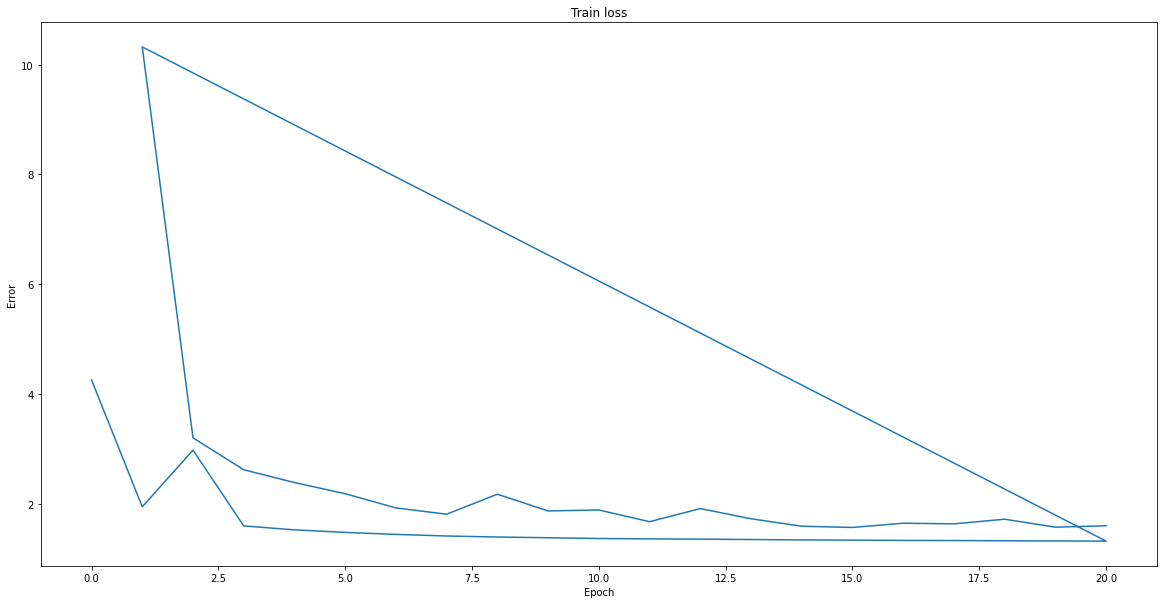

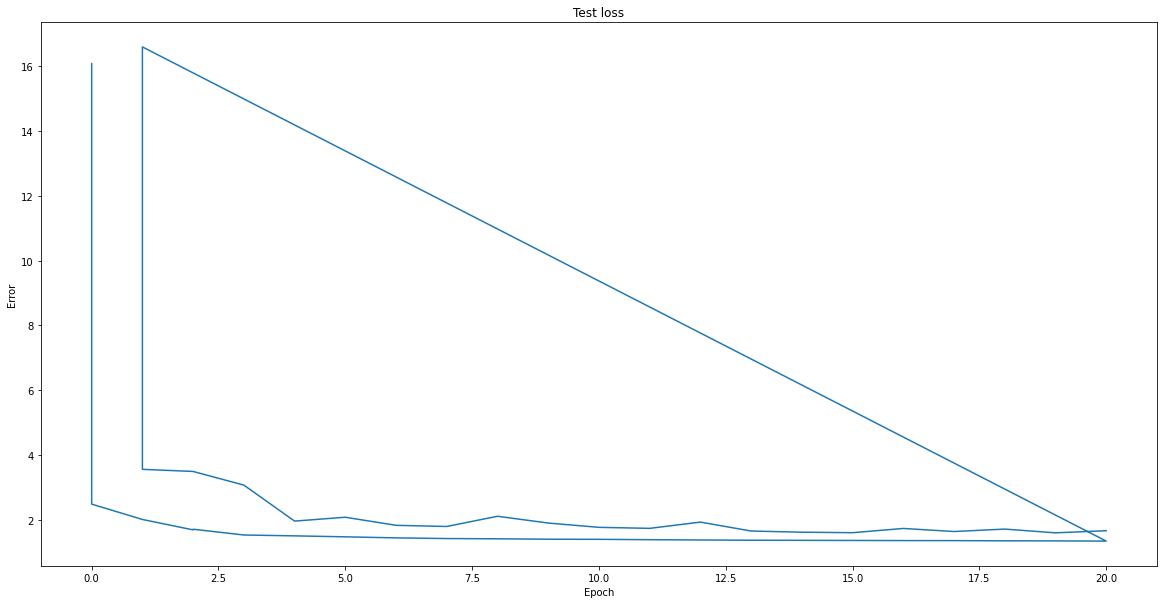

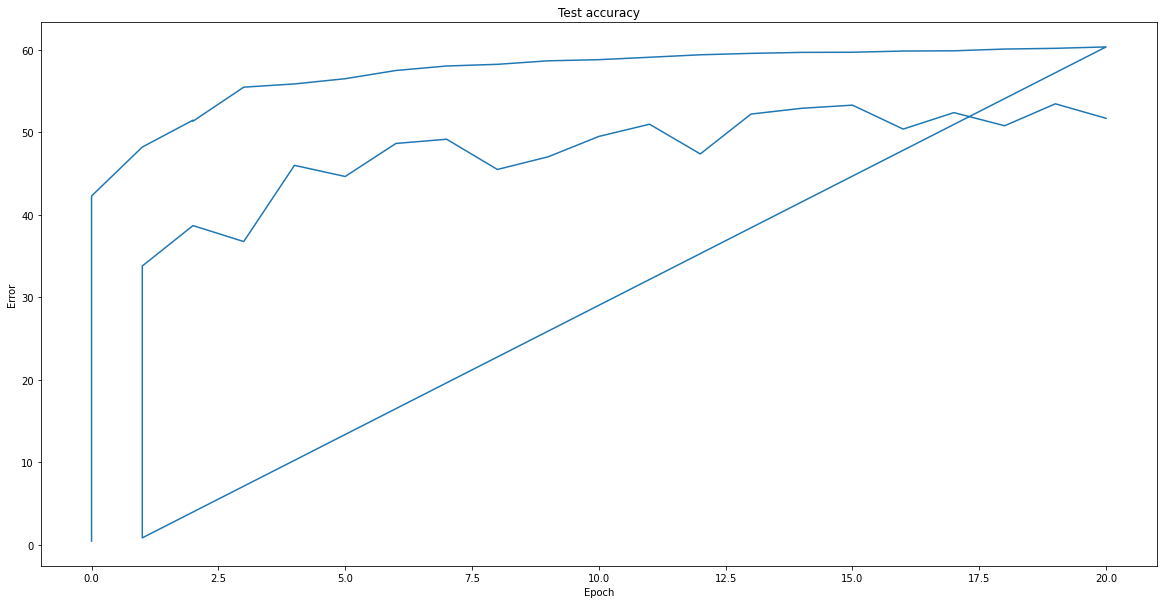

In [20]:
def main():
    SEQUENCE_LENGTH = 150
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = 1 # model.load_last_model(DATA_PATH + 'checkpoints')

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)
            seed_words = 'Arthur saw his house had been buldozed by '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        return model, vocab, device

final_model, vocab, device = main()

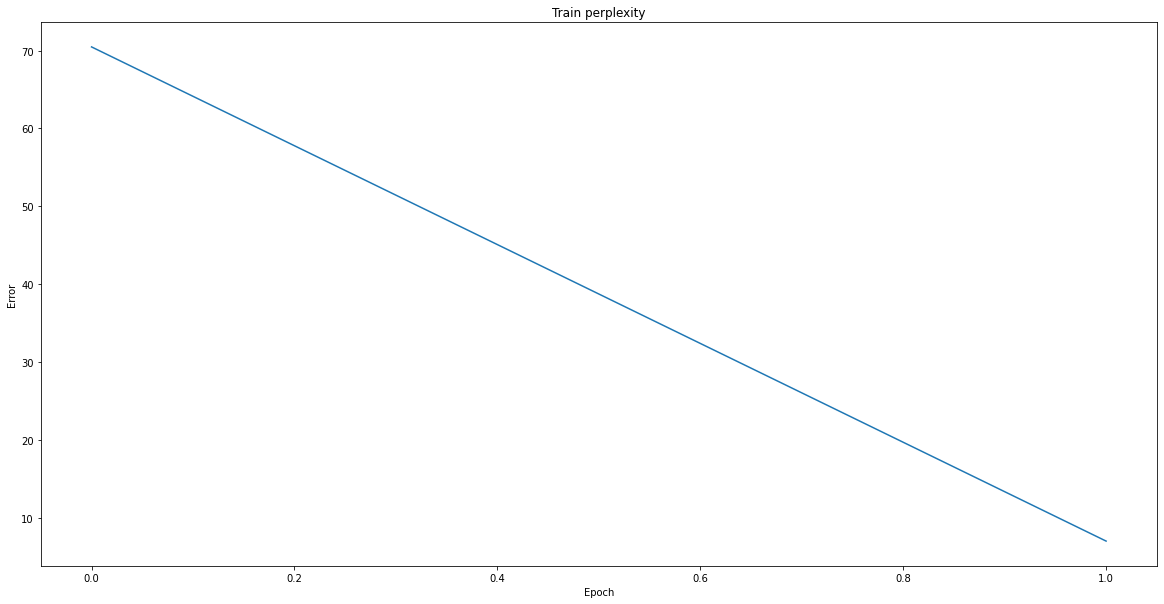

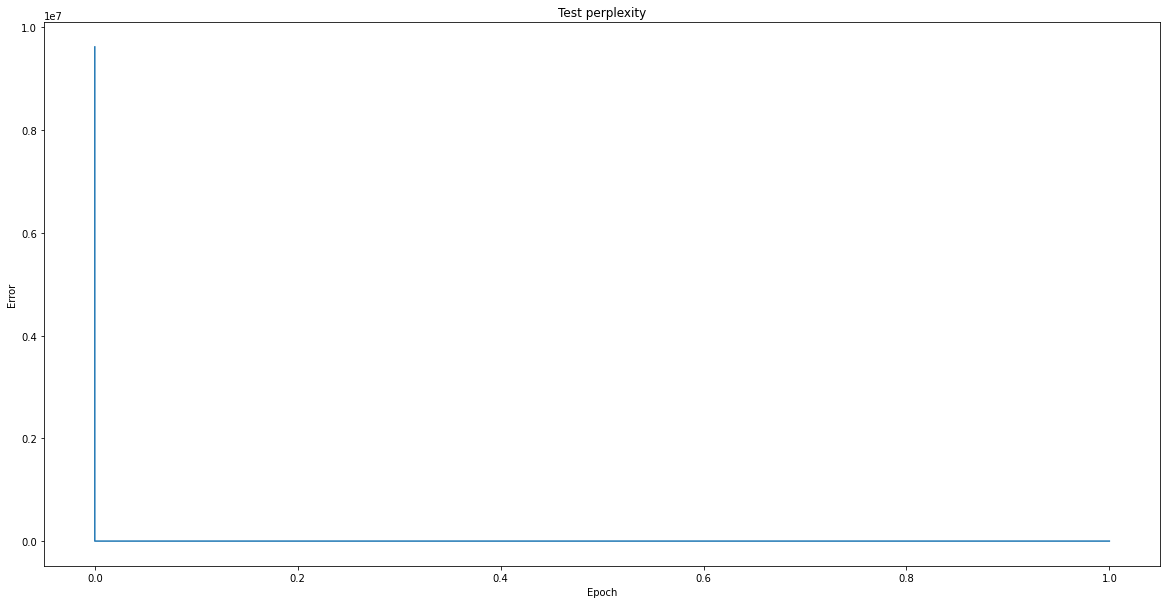

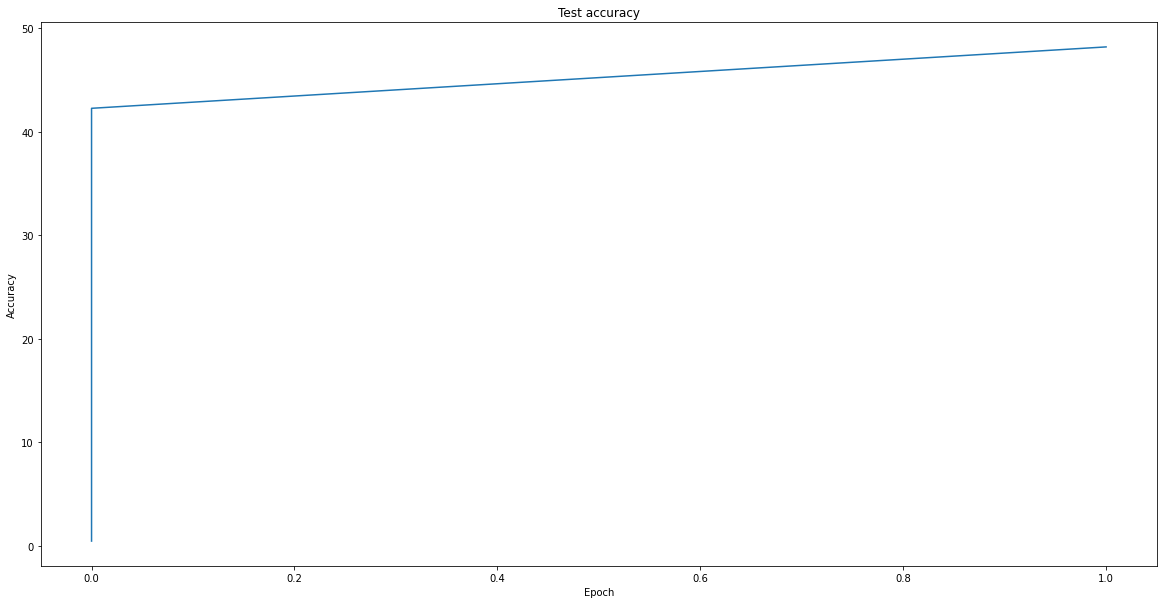

IndexError: ignored

In [11]:
# plot perplexity
LOG_PATH = DATA_PATH + 'logs/log.pkl'
train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
ep, val = zip(*train_losses)
perp = list(map(math.exp, val))
pt_util.plot(ep[-20:], perp[-20:], 'Train perplexity', 'Epoch', 'Error')

ep, val = zip(*test_losses)
val = list(map(math.exp, val))
pt_util.plot(ep[-20:], val[-20:], 'Test perplexity', 'Epoch', 'Error')

ep, acc = zip(*test_accuracies)
pt_util.plot(ep[-20:], acc[-20:], 'Test accuracy', 'Epoch', 'Accuracy')

print(acc[19])
print(acc[-1])
print(val[-1])

#Part 7: Experiments

In [ ]:
def eval_final_model(model, vocab, device):
    seed_words = 'What is the meaning of life, the universe and everything?'
    sequence_length = 70

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

#Part 8: Other things
Choose **three** of the following to try. You should create new code cells below rather than modifying your earlier code:


1. Train on a different text corpus. The corpus should be at least as large as the provided Harry Potter dataset.
    - Options include other books, websites, tweets, wikipedia articles etc.
    -  (Hint: this is probably the easiest one)
1. Find a better network architecture. Some ideas:
    - Look at the various options in https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    - You can make the network wider or deeper.
    - You can try to learn separate encoders and decoders.
1. Use an LSTM instead of a GRU.
    - https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM
    - The output of an LSTM is a hidden state **and** a cell state, so you will need to deal with a tuple instead of a single vector.
1. Use a Transformer instead of a GRU.
    - https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer
    - Be sure to get the masks right so you don't condition on the future characters: https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer.generate_square_subsequent_mask may be of use.
1. Train a model using student-forcing.
    - You will have to modify the network inputs.
    - You will need to use `torch.nn.GRUCell` and its like. https://pytorch.org/docs/stable/nn.html#grucell
    - You cannot simply feed an empty string to start off a sequence. The sequence must be somehow conditioned on prior ground truth.
1. Train a model on words instead of characters.
    - You will need to redefine your input/output space vocabulary as well.
    - You should replace any words that occur less than 5 times in the dataset with an <unknown\> token. 
1. Write a new data loader which picks a random point in the text to start from and returns 10 consecutive sequences starting from that point onward. 
    - You should also modify the train and test functions to reset the memory when you reset the sequence.
    - You should consider an epoch to be feeding in approximately the number of characters in the dataset.
    - You may run into issues if your dataset size/epochs are not a multiple of your batch size.
1. Train on sentences instead of one long sequence.
    - You should still produce output character by character.
    - Sentences can end with a . ! ?, but words like Mr. generally do not end a sentence.
    - A sentence may also continue in the case of quotations. For example: ``"Do your homework!" said the TAs.`` is only one sentence.
    - Your parsing does not have to be perfect, but try to incorporate as many of these rules as you can.
    - Feel free to use existing NLP tools for finding sentence endings. One is spacy: https://spacy.io/usage/linguistic-features#section-sbd
    - All sentences should end with an <eos\> token. Your output sampling should now stop when it produces the <eos\> token.



#Part 9: Short answer questions
Please answer these questions, and put the answers in a file called short_answer.pdf in your repository.


1. Just like last time, provide plots for training error, test error, and test accuracy. Also provide a plot of your train and test perplexity per epoch.
    - In class we defined perplexity as `2^(p*log_2(q))`, However the PyTorch cross entropy function uses the natural log. To compute perplexity directly from the cross entropy, you should use `e^p*ln(q)`.
    - We encourage you to try multiple network modifications and hyperparameters, but you only need to provide plots for your best model. Please list the modifications and hyperparameters.    
    
2. What was your final test accuracy? What was your final test perplexity?
3. What was your favorite sentence generated via each of the sampling methods? What was the prompt you gave to generate that sentence?
4. Which sampling method seemed to generate the best results? Why do you think that is?
5. For sampling and beam search, try multiple temperatures between 0 and 2. 
    - Which produces the best outputs? Best as in made the most sense, your favorite, or funniest, doesn't really matter how you decide.
    - What does a temperature of 0 do? What does a temperature of 0<temp<1 do? What does a temperature of 1 do? What does a temperature of above 1 do? What would a negative temperature do (assuming the code allowed for negative temperature)?
    
Questions for each of the "Other things" sections. Only answer the questions corresponding to the ones you chose.

1. New Corpus
    1. What corpus did you choose? How many characters were in it?
    2. What differences did you notice between the sentences generated with the new/vs old corpus.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. New Architecture
    1. What was your design? What did you try that didn't work well?
    2. What was your lowest test perplexity? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. LSTM
    1. What new difficulties did you run into while training?
    2. Were results better than the GRU? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. Transformer
    1. What new difficulties did you run into while training?
    2. Were results better than the GRU? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).
    
1. Student-forcing
    1. What new difficulties did you run into while training?
    2. Were the results better than with teacher-forcing?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was).
    
1. Words
    1. What new difficulties did you run into while training?
    2. How large was your vocabulary?
    3. Did you find that different batch size, sequence length, and feature size and other hyperparameters were needed? If so, what worked best for you?

1. Random Dataloader
    1. What new difficulties did you run into while training?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 
    
1. Sentences
    1. What new difficulties did you run into while training? What new difficulties did you run into while preprocessing?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 


    